<a href="https://colab.research.google.com/github/Onase01/Onase01/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import some libraries to use for the image processing and analysis
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import skimage 
from skimage.filters import threshold_otsu
import cv2
import os
# get the current working directory
current_direc = os.getcwd()
print(current_direc)

/content


In [ ]:
from numpy.lib.type_check import imag
# defining function that performs several computation for the image analysis task

def show_image(ax, image, title):
    """
    This function displays the selected skin image

    param: ax represents the axis to be plotted
    param: image represents the image to show
    param: title represents the title of the image.
    """
    im = ax.imshow(image, plt.cm.gray, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')

"""
This function binarizes an image
:param: image represents the image which we wish to binarize
:return: binary represents image which has been binarized. However, it might contain some holes.
       : new_filled represents image which has been completely binarized. This image should be free of 
         holes within our region of interest.


"""
def binarized_image(image):
    # convert image to a gray scale image
    gray_skin_image = color.rgb2gray(image)
    # blur the image to get good edges
    blurred_image = skimage.filters.gaussian(gray_skin_image, sigma=1.0)

    # define a threshold using threshold otsu to filter image
    thresh = threshold_otsu(blurred_image)
    
        
    # convert the image to a gray scale image
    # binarize the image  

    nnew_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.blur(src=nnew_image, ksize=(3, 4))
    ret,binary = cv2.threshold(blurred, int(thresh*129),255,cv2.THRESH_BINARY)
         
    # this is how we imagine the object to look like
    # we expect a perfect asphalt object to be all black
    # first, we need to convert the image to a grayscale
    # then, we binarize the image, making sure every white spot within the dark part of the image is made dark
    # the essence of this is to get a good value for area
    imaginary_view = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_imaginary_view = cv2.blur(imaginary_view, ksize=(3, 4))
  
    ret2,binary2 = cv2.threshold(blurred_imaginary_view, int(thresh*255),255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(binary2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # get the length of the contour
    # filling the holes not completely binarized
    len_contour = len (contours) 
    contour_list = []
    for i in range(len_contour):
        # create a black image
        black_image = np.zeros_like(binary2, np.uint8)  
        black_img_contour = cv2.drawContours(black_image, contours, i, (255, 255, 255), thickness = cv2.FILLED)
        contour_list.append(black_img_contour)

    filled = sum(contour_list)
    # invert the object.
    # by inverting we mean, turning all white to black, and vice versa.
    new_filled = cv2.bitwise_not(filled)
    
    # erode and dilate the image to properly binarized the area of interest.
    #kernel = np.ones((3,3), np.uint8)
    kernel = np.ones((15,15), np.uint8)
    #Erode,fill up white spaces,Dilate fill the black
    new_filled = cv2.erode(new_filled, kernel, iterations = 2) 
    new_filled = cv2.dilate(new_filled, kernel, iterations = 2)

    return binary, new_filled, imaginary_view        

"""
This function calculates the area of the pixel occupied by the binarized image.
@ param: image_binarized represents the binarized image
@ return: area represents the area of the pixel occupied by the dark point(pixels) of the binarized image.
"""
def area_material(image_binarized):
  # get the area occupied by the material
  area_occupied = (image_binarized == 0)
  area = np.sum(area_occupied)

  return area


In [ ]:
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


binarized_Image Area is : 222615
Solid Black Contour Area is : 268940
white percentage:  17.2250%


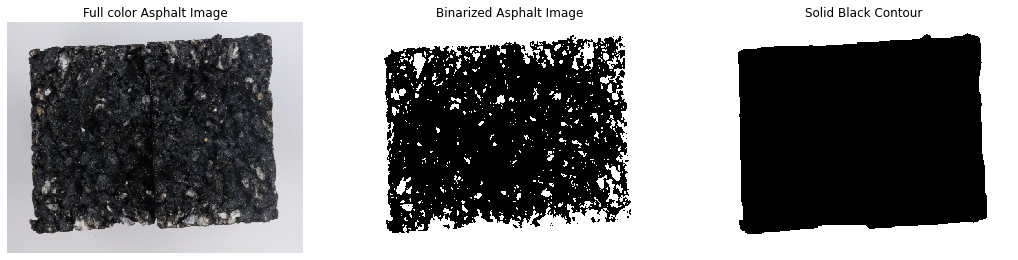

In [ ]:
# load the image
#stone_image_path = "paste the image path"

# check if the path is a png.
# if yes, convert it to a jpg

# split the image path which is a string seperated by .
get_path = stone_image_path.split(".")
if get_path[-1].lower() == "png":
  img = Image.open(stone_image_path)
  rgb_img = Image.new('RGB', img.size, (255, 255, 255))
  #rgb_img = Image.new('RGB', img.size, (100, 100, 100))
  rgb_img.paste(img, img)
  rgb_img.save('image.jpg')
  stone_image_path = "/content/image.jpg"
  
stone_image = plt.imread(stone_image_path)
# We realized image width and height including pixels was too high.
# resize the image to avoid OOM.
# Resize while avoiding image distortion.
stone_image = cv2.resize(stone_image,(int(stone_image.shape[1]/4),int(stone_image.shape[0]/4)), interpolation = cv2.INTER_AREA)
#binarize the image
bin1, bin2, image_in_gray = binarized_image(stone_image)

fig, ax = plt.subplots(ncols=3, figsize=(18,5))
show_image(ax[0], stone_image, "Full color Asphalt Image")
show_image(ax[1], bin1, "Binarized Asphalt Image")

show_image(ax[2], bin2, "Solid Black Contour")


#plt.suptitle("A picture showing an Asphalt sample binarized and its percentage of aggregate")
#plt.show()

binarized_image_area = area_material(bin1)
Imaginary_image_area = area_material(bin2)
print("binarized_Image Area is :", binarized_image_area)
print("Solid Black Contour Area is :",Imaginary_image_area)

number_of_white = Imaginary_image_area - binarized_image_area
percentage_value = (number_of_white/ Imaginary_image_area) * 100

print("white percentage:  {:.4f}%".format(percentage_value))
